In [1]:
import numpy as np
import pandas as pd
import pickle
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels import multivariate
from statsmodels import regression
import scipy.stats as stats
from statsmodels.sandbox.regression import gmm
from statsmodels.sandbox.regression.gmm import GMM
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.adfvalues import mackinnonp, mackinnoncrit
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.hypothesis_test_results import CausalityTestResults
from statsmodels.tsa.vector_ar.var_model import VAR, VARProcess, VARResults
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order
import statsmodels.tsa.arima_model as am
from statsmodels.regression.rolling import RollingOLS

from tabulate import tabulate

import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import timedelta


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator
from matplotlib.ticker import PercentFormatter


import os
import warnings

from scipy.optimize import minimize, brute
from arch import arch_model


warnings.filterwarnings("ignore")

In [23]:
rr = pd.read_csv("rt.csv",parse_dates = True)
rr.date = pd.to_datetime(rr.date)
uspolicy = pd.read_csv('stateMandateList_v3.csv',parse_dates = True)

In [28]:
countries = rr.region.unique()
r_mean = []
dates = []
for c in countries:
    temp_df = rr[rr.region == c]
    dates.append(temp_df.date.values)
    r_mean.append(temp_df['mean'].values)

In [30]:
ans1 = pd.DataFrame([dates[0],r_mean[0]]).T
ans1.columns = ['Date',countries[0]]


for i in range(1,len(countries)):
    ans2 = pd.DataFrame([dates[i],r_mean[i]]).T
    ans2.columns = ['Date',countries[i]]
    ans2.index = ans2['Date']
    ans1 = ans1.join(ans2,on = 'Date',rsuffix = 'r')
    
ans1 = ans1.drop(['Dater'],axis = 1)
ans1.iloc[0] = ans1.iloc[0].fillna(0)
ans1 = ans1.ffill()

In [71]:
ans1.iloc[3:,1:]

,ME,NH,VT,MA,RI,CT,NY,NJ,PA,DE,...,MT,ID,UT,AZ,WA,OR,NV,CA,AK,HI
3,1.338407,1.752279,1.665421,2.869802,2.446147,2.992981,4.596007,3.866422,3.191397,2.017822,...,1.388155,2.171793,2.247825,2.608070,1.749103,1.877678,2.259697,2.430053,0.000000,1.312898
4,1.330090,1.747549,1.647476,2.856483,2.430029,2.959749,4.400554,3.764901,3.145796,2.011759,...,1.374405,2.156575,2.206443,2.578119,1.677361,1.859460,2.237774,2.391080,0.000000,1.304435
5,1.322189,1.737841,1.623582,2.822855,2.410214,2.917489,4.165521,3.650147,3.087386,2.001824,...,1.363870,2.144156,2.158050,2.537973,1.608714,1.838010,2.210591,2.345589,0.000000,1.294703
6,1.313737,1.723064,1.596153,2.786498,2.383844,2.867747,3.895209,3.514532,3.018650,1.986269,...,1.346478,2.122279,2.103402,2.485631,1.544916,1.806809,2.178165,2.289292,1.089838,1.285169
7,1.304016,1.709918,1.564778,2.728546,2.359728,2.813708,3.595541,3.373159,2.932135,1.975196,...,1.324486,2.093160,2.040445,2.421713,1.482311,1.773027,2.138772,2.232874,1.086605,1.270837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,0.978181,0.991766,1.147161,0.908937,0.921046,0.976633,0.920545,0.949580,0.897038,0.982705,...,0.867622,0.839258,0.914582,0.960066,0.917996,0.872324,0.937093,0.809786,0.802096,1.124140
327,0.977916,0.991800,1.148449,0.911445,0.919141,0.978016,0.922057,0.949861,0.898826,0.982508,...,0.869051,0.840081,0.916482,0.961327,0.916367,0.872052,0.936135,0.809541,0.803261,1.122077
328,0.980541,0.994549,1.147626,0.912646,0.920721,0.978534,0.923722,0.949853,0.898558,0.982239,...,0.870486,0.838674,0.917027,0.960475,0.916511,0.871476,0.936456,0.810809,0.805778,1.121512
329,0.981905,0.995937,1.143954,0.914625,0.921747,0.980105,0.925815,0.950140,0.899381,0.984339,...,0.869718,0.840280,0.919257,0.959745,0.918687,0.871644,0.937009,0.809322,0.807111,1.122140


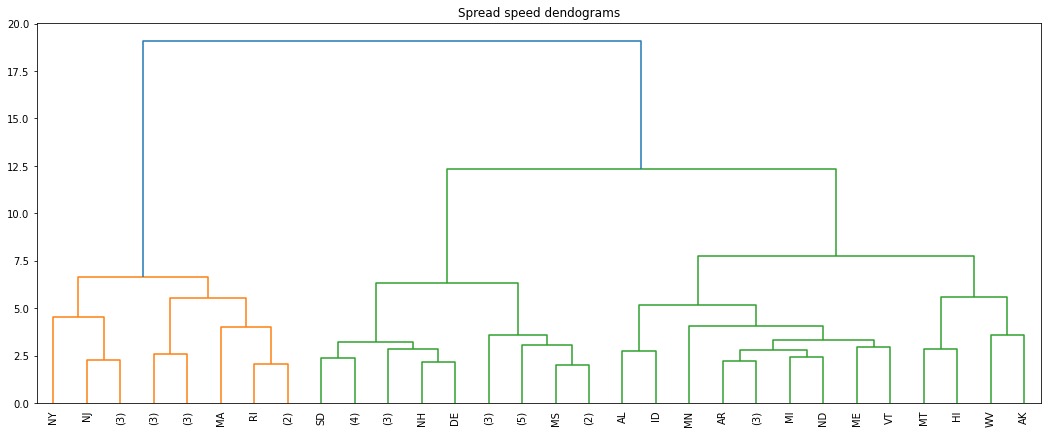

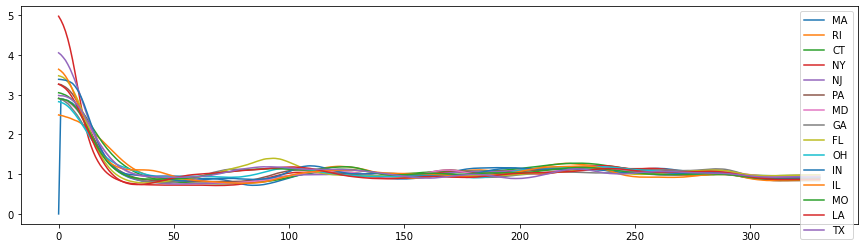

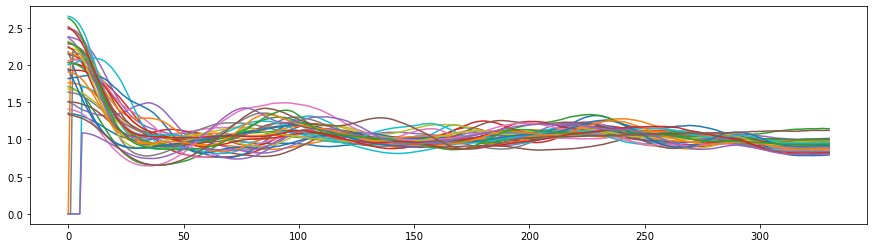

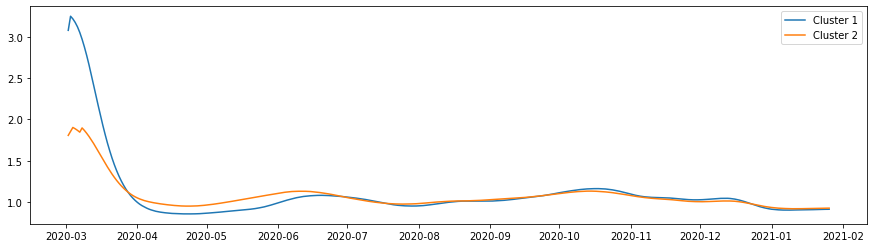

In [74]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster


cl = ans1.iloc[:,1:]
plt.figure(figsize=(18, 7))
plt.title("Spread speed dendograms")\

Z = shc.linkage(cl.T, method='ward')
dend = shc.dendrogram(Z,truncate_mode='lastp',
                      orientation='top', show_leaf_counts=True,
                     no_labels = False,labels = cl.columns,leaf_rotation = 90)
k=2
names_cl = fcluster(Z, k, criterion='maxclust')

cluster_1 = cl.columns[names_cl == 1]
cl_1 = cluster_1
cluster_2 = cl.columns[names_cl == 2]
cl_2 =  cluster_2

series_1 = ans1[cl_1]
plt.figure(figsize = (15,4))
plt.plot(series_1)
plt.legend(cl_1)
plt.show()

series_2 = ans1[cl_2]
plt.figure(figsize = (15,4))
plt.plot(series_2)
plt.show()

series_1.index = pd.to_datetime(ans1.Date)
series_2.index = pd.to_datetime(ans1.Date)

plt.figure(figsize = (15,4))
plt.plot(series_1.mean(axis = 1))
plt.plot(series_2.mean(axis = 1))
plt.legend(["Cluster 1","Cluster 2"])
plt.show()

## Graphs...

In [78]:
ans1.index = pd.to_datetime(ans1.Date)
ans1 = ans1.drop(['Date'],axis = 1)

In [86]:
muspolicy

,state,stateSymbol,maskDate1,isMaskRequired1,maskDate2,isMaskRequired2,maskDate3,isMaskRequired3,schoolClosure_m1,banGathering_m1,...,nonEssenBussiness_m2,travelQuarantine_m2,barClosure_m2,schoolClosure_e2,banGathering_e2,resturantLimit_e2,stayAtHome_e2,nonEssenBussiness_e2,travelQuarantine_e2,barClosure_e2
0,Alabama,AL,4/28/2020,0,7/16/2020,1.0,NaN,NaN,3/27/2020,3/27/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alaska,AK,4/20/2020,0,NaN,NaN,NaN,NaN,3/13/2020,3/20/2020,...,NaN,11/16/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arizona,AZ,3/30/2020,0,NaN,NaN,NaN,NaN,3/16/2020,3/30/2020,...,7/23/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arkansas,AR,5/4/2020,1,NaN,NaN,NaN,NaN,3/11/2020,3/26/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,California,CA,6/18/2020,1,NaN,NaN,NaN,NaN,NaN,3/16/2020,...,NaN,NaN,NaN,NaN,NaN,1/25/2020,1/25/2020,NaN,NaN,NaN
5,Colorado,CO,7/17/2020,1,NaN,NaN,NaN,NaN,3/18/2020,4/26/2020,...,7/21/2020,NaN,6/30/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Connecticut,CT,4/17/2020,1,NaN,NaN,NaN,NaN,3/11/2020,3/16/2020,...,11/6/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Delaware,DE,4/28/2020,1,NaN,NaN,NaN,NaN,3/13/2020,3/16/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Florida,FL,6/5/2020,0,NaN,NaN,NaN,NaN,3/17/2020,4/1/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Georgia,GA,4/13/2020,0,NaN,NaN,NaN,NaN,3/16/2020,3/23/2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
m = 'isMaskRequired1'
date_col = 'maskDate1'
by_data = ans1
response = uspolicy.copy()

def compare_measures(response = uspolicy.copy(),
                     by_data = ans1,
                     m = 'isMaskRequired1',
                     date_col = 'maskDate1',
                     du = 30,
                     dd = 30):

    mass = response[[date_col,'stateSymbol',m]]
    mass = mass[mass[m].values == 1]
    mass_countries = mass.stateSymbol.unique()

    policy_matrix = pd.DataFrame(columns = mass_countries, index= pd.to_datetime(by_data.index)).fillna(0)

    for c in mass_countries:
        df_temp = mass[mass.stateSymbol == c]
        try:
            policy_matrix.loc[df_temp[date_col].iloc[0],c] = 1
        except:
            pass
        
    policy_matrix = policy_matrix.dropna()
    changes_before_after = pd.DataFrame(index = np.arange(-dd,du+1),columns = policy_matrix.columns)
    for c in policy_matrix.columns:
        row = policy_matrix[c]
        pdate = row[row == 1].index[0]
        temp_change = by_data.loc[pdate - relativedelta(days = du):
                                  pdate + relativedelta(days = dd),c]*100

        if(temp_change.shape[0] <= du+dd):
            changes_before_after.loc[0 - temp_change[:pdate].shape[0]:-1,c] = temp_change[:pdate].values

            changes_before_after.loc[0: 0 + temp_change[pdate:].shape[0],c] = temp_change[pdate:].values
        else:

            changes_before_after.loc[0 - temp_change[:pdate].shape[0]:
                                     -1,c] = temp_change[:pdate-relativedelta(days = 1)].values

            changes_before_after.loc[0: 0 + temp_change[pdate:].shape[0],c] = temp_change[pdate:].values
            
    return changes_before_after.replace([np.inf, -np.inf], np.nan)

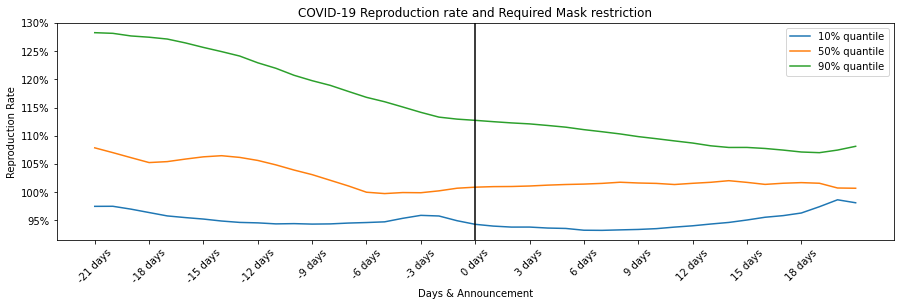

In [210]:
m = 'isMaskRequired2'
date_col = 'maskDate2'
title = 'Required Mask restriction'


md = compare_measures(response = uspolicy.copy(),
                     by_data = ans1,
                      m = m,
                      date_col = date_col)

dd = 21
du =21
md = md.loc[-dd:du]
plt.figure(figsize = (15,4))
md.T.quantile(0.1).plot()
md.T.quantile(0.5).plot()
md.T.quantile(0.9).plot()

plt.axvline(x = 0 , c = 'black')
plt.title("COVID-19 Reproduction rate and " + title)
plt.ylabel('Reproduction Rate')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.legend(['10% quantile',
           '50% quantile',
           '90% quantile'])

plt.show()

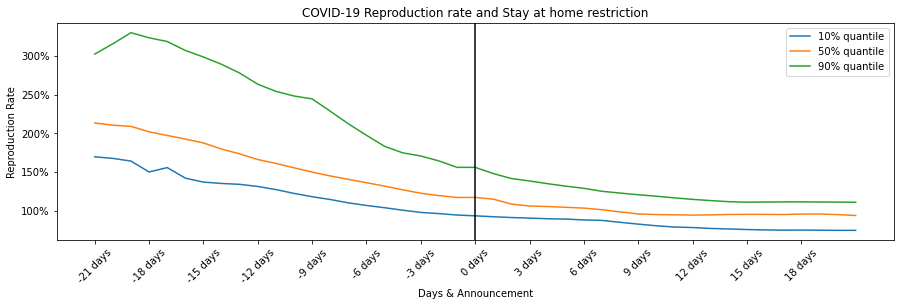

In [211]:
m = 'stayAtHome_m1'+'_indicator'
date_col = 'stayAtHome_m1'

title = 'Stay at home restriction'
uspolicy[m] = uspolicy[date_col].fillna(0) != 0

md = compare_measures(response = uspolicy.copy(),
                     by_data = ans1,
                      m = m,
                      date_col = date_col)
dd = 21
du =21
md = md.loc[-dd:du]
plt.figure(figsize = (15,4))
md.T.quantile(0.1).plot()
md.T.quantile(0.5).plot()
md.T.quantile(0.9).plot()

plt.axvline(x = 0 , c = 'black')
plt.title("COVID-19 Reproduction rate and " + title)
plt.ylabel('Reproduction Rate')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.legend(['10% quantile',
           '50% quantile',
           '90% quantile'])

plt.show()

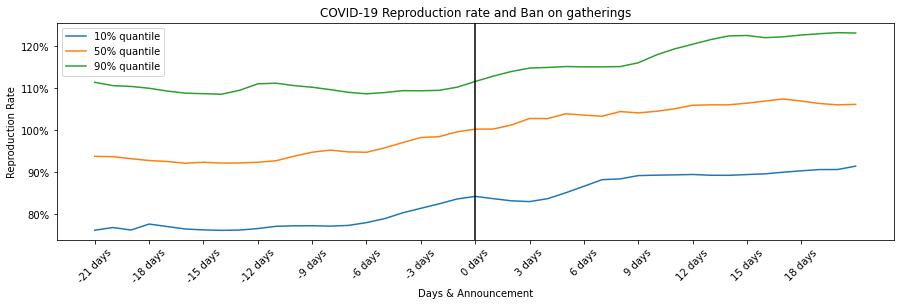

In [212]:
m = 'banGathering_e1'+'_indicator'
date_col = 'banGathering_e1'

title = 'Ban on gatherings'
uspolicy[m] = uspolicy[date_col].fillna(0) != 0

md = compare_measures(response = uspolicy.copy(),
                     by_data = ans1,
                      m = m,
                      date_col = date_col)
dd = 21
du =21
md = md.loc[-dd:du]

plt.figure(figsize = (15,4))
md.T.quantile(0.1).plot()
md.T.quantile(0.5).plot()
md.T.quantile(0.9).plot()


plt.axvline(x = 0 , c = 'black')
plt.title("COVID-19 Reproduction rate and " + title)
plt.ylabel('Reproduction Rate')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.legend(['10% quantile',
           '50% quantile',
           '90% quantile'])
plt.show()

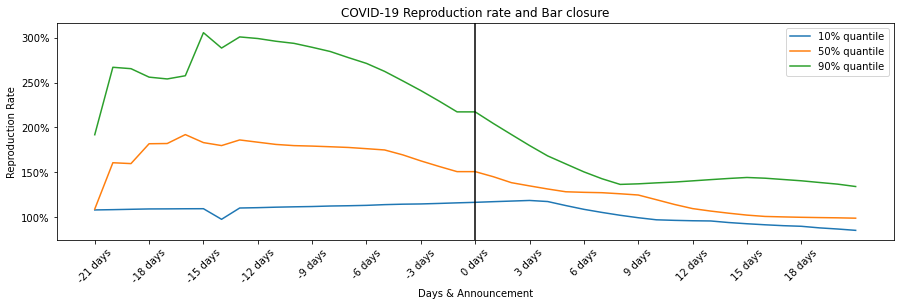

In [213]:
m = 'barClosure_m1'+'_indicator'
date_col = 'barClosure_m1'

title = 'Bar closure'
uspolicy[m] = uspolicy[date_col].fillna(0) != 0

md = compare_measures(response = uspolicy.copy(),
                     by_data = ans1,
                      m = m,
                      date_col = date_col)
dd = 21
du =21
md = md.loc[-dd:du]
plt.figure(figsize = (15,4))
md.T.quantile(0.1).plot()
md.T.quantile(0.5).plot()
md.T.quantile(0.9).plot()


plt.axvline(x = 0 , c = 'black')
plt.title("COVID-19 Reproduction rate and " + title)
plt.ylabel('Reproduction Rate')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.legend(['10% quantile',
           '50% quantile',
           '90% quantile'])
plt.show()

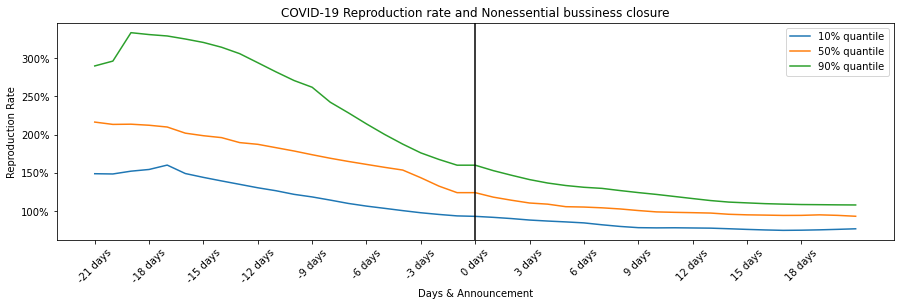

In [214]:
m = 'nonEssenBussiness_m1'+'_indicator'
date_col = 'nonEssenBussiness_m1'

title = 'Nonessential bussiness closure'
uspolicy[m] = uspolicy[date_col].fillna(0) != 0

md = compare_measures(response = uspolicy.copy(),
                     by_data = ans1,
                      m = m,
                      date_col = date_col)
dd = 21
du =21
md = md.loc[-dd:du]
plt.figure(figsize = (15,4))
#md.mean(axis = 1).plot()
md.T.quantile(0.1).plot()
md.T.quantile(0.5).plot()
md.T.quantile(0.9).plot()


plt.axvline(x = 0 , c = 'black')
plt.title("COVID-19 Reproduction rate and " + title)
plt.ylabel('Reproduction Rate')
plt.xlabel("Days & Announcement")
plt.xticks(ticks = np.arange(-dd,du,3),
           labels = list(map(lambda x: str(x)+ ' days',np.arange(-dd,du,3))),
          rotation=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.legend(['10% quantile',
           '50% quantile',
           '90% quantile'])
plt.show()